In [49]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

urlTrain  = 'https://raw.githubusercontent.com/CyberJuan55/Proyecto-IA/master/DataSet/SpotifyFeatures_train.csv'
urlFull = 'https://raw.githubusercontent.com/CyberJuan55/Proyecto-IA/master/DataSet/SpotifyFeatures.csv'
# el train que nos dieron los profes
#df_train_original= pd.read_csv('/content/SpotifyFeatures_train.csv')
df_train_original = pd.read_csv(urlTrain)
df_train = df_train_original.copy()
# el dataset nuestro
df_full_original = pd.read_csv(urlFull)
df_full = df_full_original.copy()


### Preprocesado de datos

In [50]:
# Funcion para el preprocesamiento de datos


def preprocesado(df):

    

    if df.duplicated().sum() == 0:
        print('no hay datos duplicados')
    else:
        df.drop_duplicates


    if 'Unnamed: 0' in df.columns:
        df = df.drop(['Unnamed: 0'], axis=1)
    else:
        print('no esta')  
    df = df.drop_duplicates(subset=['track_name','artist_name'],keep=False)
    df = df.drop(['time_signature','track_id','artist_name','track_name','speechiness'], axis=1)
    df['genre']= df['genre'].replace(["Children’s Music"],"Children's Music")
    indexNamesChildren = df[ df['genre'] == "Children's Music" ].index
    df.drop(indexNamesChildren , inplace=True)
    
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()] 
    faltanDatos = True
    if len(cols_with_missing)==0:
        faltanDatos= False
        print('no faltan valores') 
    if faltanDatos == True:
        print(cols_with_missing)
        df.dropna(axis=0, inplace=True)

    X = df.drop(columns=['genre'])
    y = df['genre']
    

    return X,y 


In [51]:
df_train,y = preprocesado(df_train)

no hay datos duplicados
no faltan valores


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad6c62f210>,
      dtype=object)

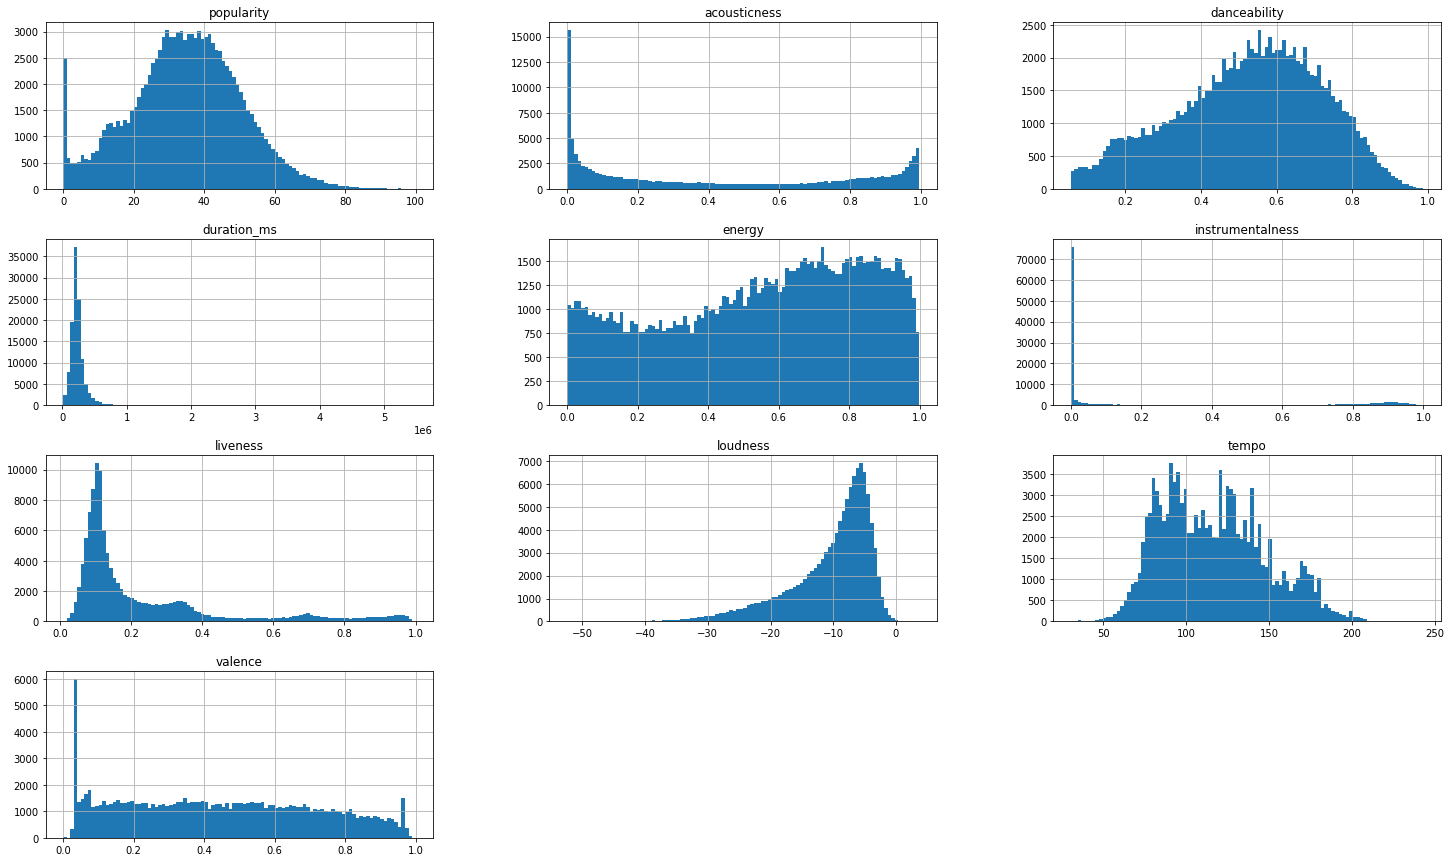

In [52]:
df_train.hist(bins=100, figsize=(25,15))

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_train, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [54]:
df_train_num = X_train_full.drop(["key",'mode'], axis=1)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
cat_attribs1 = ["key"]
cat_attribs2 = ["mode"]
num_attribs = list(df_train_num)

full_pipeline = ColumnTransformer([
        ('numerical', num_pipeline, num_attribs),                          
        ("cat", OrdinalEncoder(), cat_attribs1),
        ("cat1", OrdinalEncoder(), cat_attribs2)
    ])


In [56]:
df_train_processed = full_pipeline.fit_transform(df_train)

In [57]:
a = pd.DataFrame(df_train_processed)

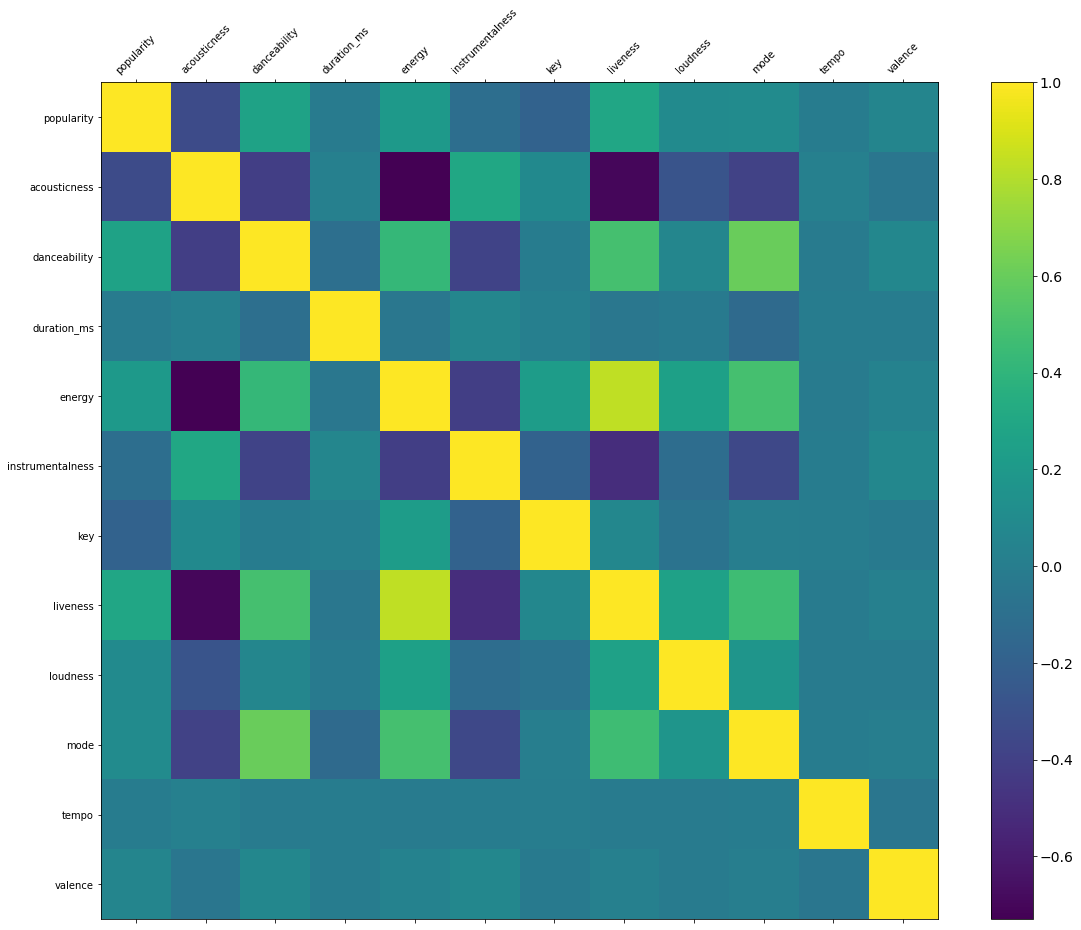

In [58]:
f = plt.figure(figsize=[19,15])
plt.matshow(a.corr(),fignum=f.number)
plt.xticks(range(a.shape[1]),df_train.columns,rotation=45)
plt.yticks(range(a.shape[1]),df_train.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [60]:
from sklearn.decomposition import PCA
dim=[]
var=[]
for comp in range(3, df_train_processed.shape[1]):
    dim.append(comp)
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df_train_processed)
    comp_check = pca.explained_variance_ratio_
    var.append(sum(comp_check))
    final_comp = comp
    if comp_check.sum() > 0.99:
        break

[0.5174011077220976, 0.6788622834406346, 0.7588352622940877, 0.8056257528447234, 0.8474600769897451, 0.8831319216931289, 0.9142404247957332, 0.942673396937623, 0.9610853799421178, 0.9751561564227835, 0.9862168240250734, 0.9955669301684575]


In [60]:
from sklearn.decomposition import PCA
pca = PCA()
#n_components= 9, random_state=42

In [61]:
pca.fit(a)


PCA()

In [62]:
x_pca = pca.transform(a)

In [63]:
print(x_pca.shape)
print(x_pca)

(115622, 12)
[[-3.31019158  4.50360574 -0.52363449 ...  0.19287051 -0.35998027
   0.09392731]
 [-3.36325791 -1.59002923  0.35409762 ...  0.44931425 -0.49329038
   0.35634142]
 [-4.34712877 -0.14819467 -0.6315632  ...  0.05742929 -0.3943911
   0.0475711 ]
 ...
 [-3.36728703 -1.22878545  0.03387745 ...  0.28720958  0.56863414
   0.42167905]
 [ 1.62577027 -1.76134062 -1.17456295 ...  0.1940429   0.59041157
  -0.26873135]
 [ 2.65553855  1.89164524 -1.11731136 ... -0.80517312  0.58243494
   0.47499234]]


Text(0.5, 0, 'Cantidad de componentes principales')

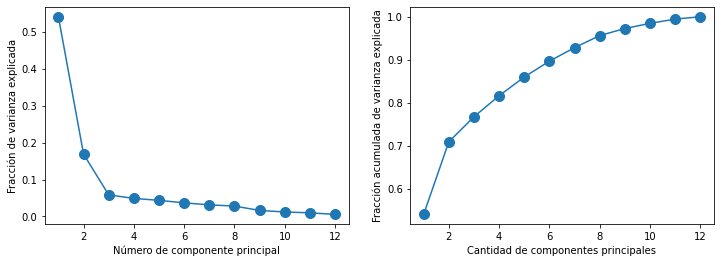

In [64]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

In [65]:
pca = PCA(n_components= 9, random_state=42)


In [30]:
lg=LogisticRegression(max_iter=2000, random_state=1, penalty = 'l2', C = 0.01) #onevsrestclassifier

In [31]:
from sklearn.pipeline import make_pipeline
LGpipe = make_pipeline(full_pipeline,pca,lg)
LGpipe.fit(X_train_full,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['key']),
                                                 ('cat1', OrdinalEncoder(),
          

In [32]:
lg_cross_val = cross_val_score(LGpipe,X_train_full,y_train,cv=5,scoring='accuracy').mean()

In [65]:
lg_cross_val

0.41292145813579406

In [66]:
params = {}

params['logisticregression__C'] = [0.1,1,10]


In [67]:
lGgrid = GridSearchCV(LGpipe, params, cv=5,scoring='accuracy' )
lGgrid.fit(X_train_full,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness'

In [68]:
lGgrid.best_score_

0.41750536990312115

### DesicionTree

In [ ]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

dtcPipe = make_pipeline(full_pipeline,dtc)
dtcPipe.fit(X_train_full,y_train)



In [ ]:
dtc_cross_val = cross_val_score(dtcPipe,X_train_full,y_train,cv=5,scoring='accuracy').mean()

In [ ]:
dtc_cross_val

0.42534350227842843

### RandomForest

In [40]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=250, random_state=42)

rfcPipe = make_pipeline(full_pipeline,pca,rfc)
rfcPipe.fit(X_train_full,y_train)




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['key']),
                                                 ('cat1', OrdinalEncoder(),
          

In [47]:
predict = rfcPipe.predict(X_valid_full)

In [48]:
print(accuracy_score(y_valid, predict))

0.41033513513513514


In [11]:
rfc_cross_val = cross_val_score(rfcPipe,X_train_full,y_train,cv=5,scoring='accuracy')

In [12]:
rfc_cross_val

0.5071839447859123

In [10]:
predict = rfc.predict(X_valid_full)
print(accuracy_score(y_valid, predict))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: ignored

###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_full, y_train)
y_pred_knn = knn.predict(X_valid_full)
print(accuracy_score(y_valid, y_pred_knn))


In [39]:
# Numero de arboles
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 8)]
# Numero de features considerado al dividir
max_features = ['auto', 'sqrt']
# numero maximo de niveles
#max_depth = [2,4]
# Numero minimo de niveles por nodo
min_samples_split = [2, 5]
# Numero minimo de niveles por hoja
min_samples_leaf = [1, 2]
# metodo de seleccion por arbol 
bootstrap = [True, False]

### GridSerchCv RandonForest

In [38]:
#'randomforestclassifier__n_jobs': None
#'randomforestclassifier__n_estimators': 30,
params = {}

params['logisticregression__C'] = [0.1,1,10]


# Grilla
param_grid = {}
param_grid['randomforestclassifier__n_estimators'] = n_estimators
param_grid['randomforestclassifier__max_features'] = max_features
#param_grid['randomforestclassifier__max_depth'] = max_depth
param_grid['randomforestclassifier__min_samples_split'] = min_samples_split
#param_grid['randomforestclassifier__min_samples_leaf'] = min_samples_leaf = [1, 2]
param_grid['randomforestclassifier__bootstrap']  = bootstrap
          
          
               #'bootstrap': bootstrap

NameError: ignored

In [15]:
from sklearn.model_selection import GridSearchCV
rfc_Grid = GridSearchCV(estimator = rfcPipe, param_grid = param_grid, cv = 5, scoring='accuracy')
#, verbose=2, n_jobs = 4

In [16]:
rfc_Grid.fit(X_train_full, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness'

In [ ]:
rfcPipe.get_params()

In [17]:
rfc_Grid.best_score_

0.5035514165119226

In [ ]:
from xgboost import XGBRegressor

XGB = XGBRegressor()



In [ ]:
XGBpipe = make_pipeline(full_pipeline, XGB)
XGBpipe.fit(X_train_full,y_train)